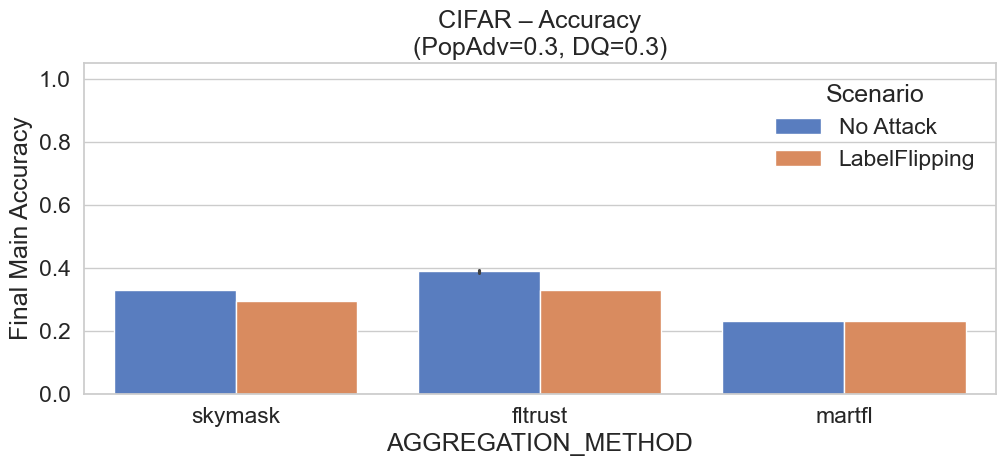

saved results\paper_figures\label_flipping_robustness_csv\acc_CIFAR_LabelFlipping.pdf


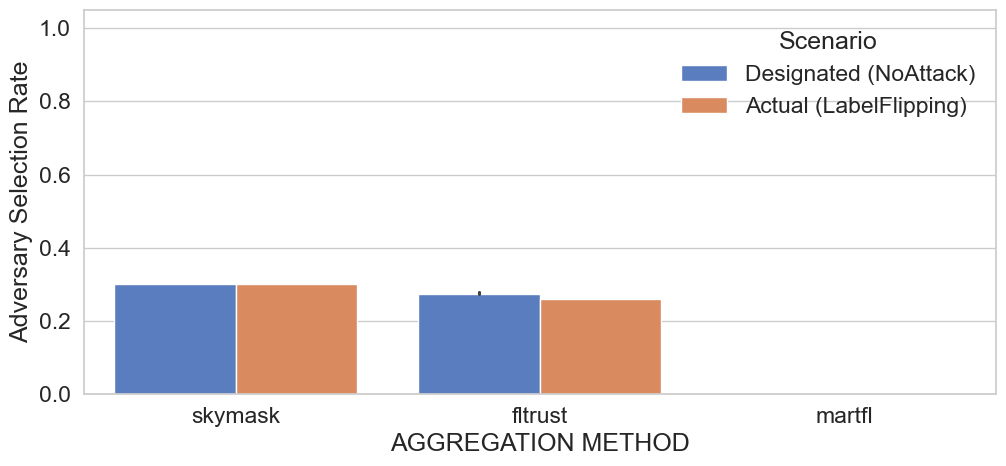

saved results\paper_figures\label_flipping_robustness_csv\sel_CIFAR_LabelFlipping.pdf


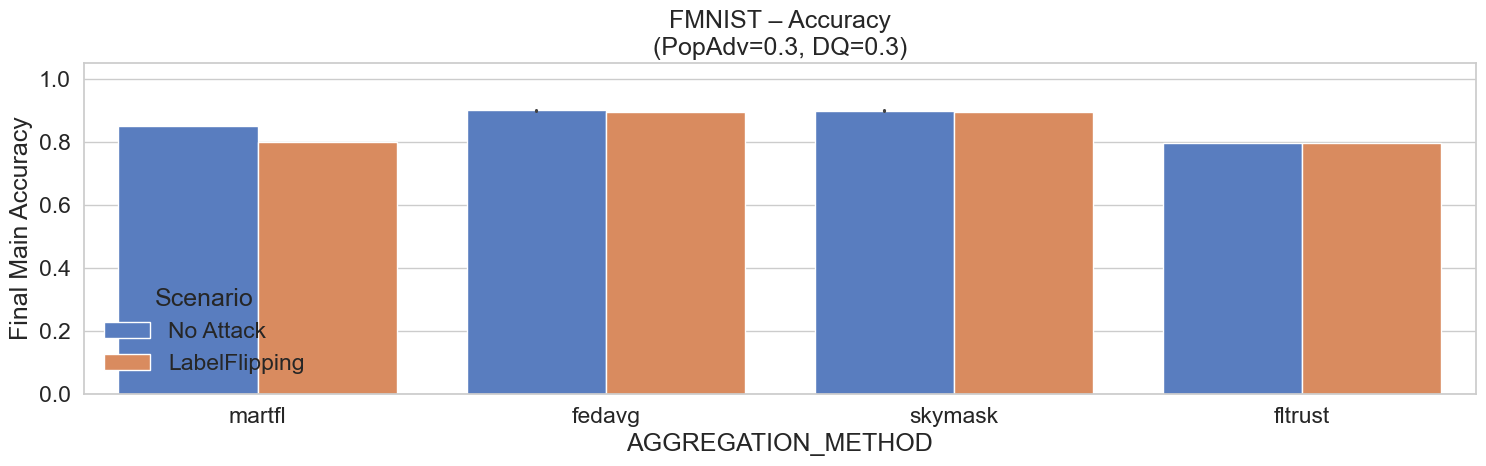

saved results\paper_figures\label_flipping_robustness_csv\acc_FMNIST_LabelFlipping.pdf


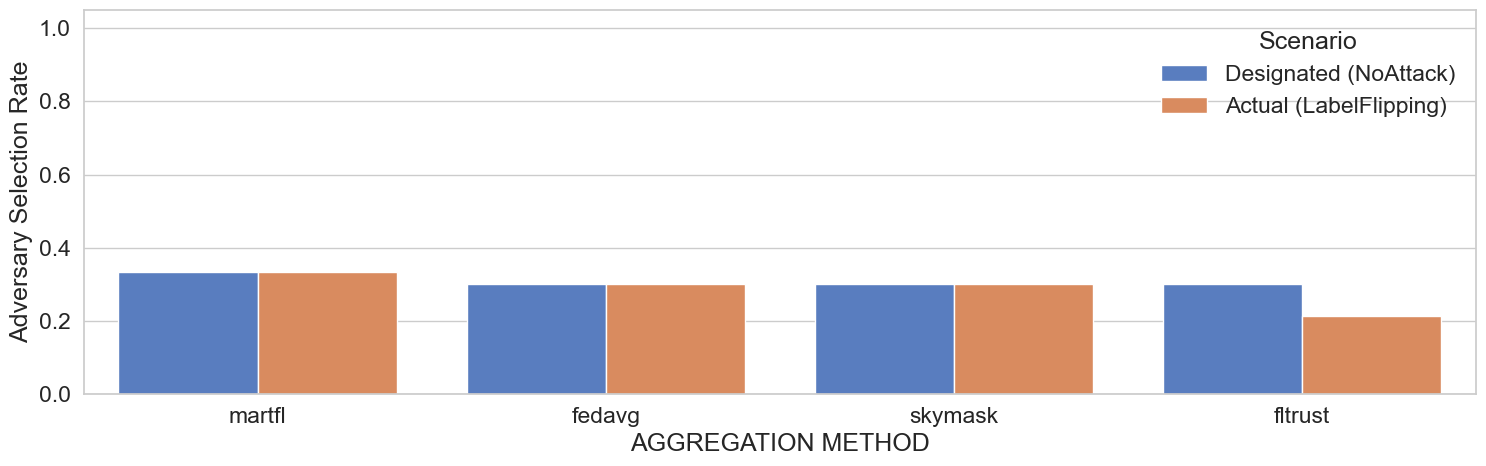

saved results\paper_figures\label_flipping_robustness_csv\sel_FMNIST_LabelFlipping.pdf
[skip] AG_NEWS: missing rows for attack=LabelFlipping


In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------------------------------------
# CONFIG – tweak as needed or turn them into CLI args
# ---------------------------------------------------------------------
CSV_PATH              = Path("../result_new/summary_avg.csv")   # your upload
FIXED_POP_ADV_RATE    = 0.3       # pair on this population rate
DISCOVERY_QUALITY     = 0.3
BUYER_MODE            = "unbiased"
SAVE_DIR              = Path("./results/paper_figures/label_flipping_robustness_csv")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
# ---------------------------------------------------------------------

ATTACK_LABELS = {
    "label_flip":  "LabelFlipping",
    "backdoor":    "Backdoor",
    None:          "NoAttack",
    "":            "NoAttack"
}

def load_and_tag(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)

    # Tag rows with an EFFECTIVE_ATTACK column
    df["EFFECTIVE_ATTACK"] = (
        df["attack_objective"]
        .map(lambda x: ATTACK_LABELS.get(str(x).strip().lower(), "UnknownAttack"))
    )

    # Derive No‑Attack rows when adv rate is 0
    df.loc[df["ADV_RATE"].eq(0), "EFFECTIVE_ATTACK"] = "NoAttack"

    # Keep separate columns for clarity
    df = df.rename(columns={"ADV_RATE": "ADV_RATE_effective"})
    df["ADV_RATE_population"] = df["ADV_RATE_effective"].where(
        df["EFFECTIVE_ATTACK"] != "NoAttack", FIXED_POP_ADV_RATE
    )
    return df

def make_barplots(df: pd.DataFrame, dataset: str, attack: str) -> None:
    """
    Produces two bar charts (accuracy & selection rate) for one dataset + attack.
    Saves them as PDF in SAVE_DIR and shows them inline.
    """
    base = df.query(
        "DATASET == @dataset and "
        "discovery_quality == @DISCOVERY_QUALITY and "
        "buyer_data_mode == @BUYER_MODE and "
        "ADV_RATE_population == @FIXED_POP_ADV_RATE"
    )

    df_attack  = base.query("EFFECTIVE_ATTACK == @attack").copy()
    df_no_atk  = base.query("EFFECTIVE_ATTACK == 'NoAttack'").copy()

    if df_attack.empty or df_no_atk.empty:
        print(f"[skip] {dataset}: missing rows for attack={attack}")
        return

    paired = pd.merge(
        df_attack[["AGGREGATION_METHOD", "FINAL_MAIN_ACC",
                   "AVG_ADVERSARY_SELECTION_RATE"]],
        df_no_atk[["AGGREGATION_METHOD", "FINAL_MAIN_ACC",
                   f"NO_ATTACK_DESIG_MAL_SEL_RATE_{FIXED_POP_ADV_RATE:.1f}"]],
        on="AGGREGATION_METHOD",
        suffixes=("_attack", "_baseline")
    )

    # ---------- Accuracy ----------
    acc_long = paired.melt(id_vars="AGGREGATION_METHOD",
                           value_vars=["FINAL_MAIN_ACC_baseline",
                                       "FINAL_MAIN_ACC_attack"],
                           var_name="Scenario", value_name="Accuracy")
    acc_long["Scenario"] = acc_long["Scenario"].map({
        "FINAL_MAIN_ACC_baseline": "No Attack",
        "FINAL_MAIN_ACC_attack":   attack
    })

    plt.figure(figsize=(2 + 1.2*len(paired), 5))
    sns.barplot(data=acc_long,
                x="AGGREGATION_METHOD", y="Accuracy", hue="Scenario",
                order=paired["AGGREGATION_METHOD"])
    plt.ylim(0, 1.05); plt.ylabel("Final Main Accuracy")
    plt.title(f"{dataset} – Accuracy\n(PopAdv={FIXED_POP_ADV_RATE}, DQ={DISCOVERY_QUALITY})")
    plt.tight_layout()
    fname = SAVE_DIR / f"acc_{dataset}_{attack}.pdf"
    plt.savefig(fname); plt.show()
    print("saved", fname)

    # ---------- Selection rate ----------
    sel_long = paired.melt(id_vars="AGGREGATION_METHOD",
                           value_vars=[f"NO_ATTACK_DESIG_MAL_SEL_RATE_{FIXED_POP_ADV_RATE:.1f}",
                                       "AVG_ADVERSARY_SELECTION_RATE"],
                           var_name="Scenario", value_name="SelRate")
    sel_long["Scenario"] = sel_long["Scenario"].map({
        f"NO_ATTACK_DESIG_MAL_SEL_RATE_{FIXED_POP_ADV_RATE:.1f}": "Designated (NoAttack)",
        "AVG_ADVERSARY_SELECTION_RATE": f"Actual ({attack})"
    })

    plt.figure(figsize=(2 + 1.2*len(paired), 5))
    sns.set_context("notebook", font_scale=1.5)
    sns.barplot(data=sel_long,
                x="AGGREGATION_METHOD", y="SelRate", hue="Scenario",
                order=paired["AGGREGATION_METHOD"])
    plt.xlabel("AGGREGATION METHOD", fontsize=18)

    plt.ylim(0, 1.05); plt.ylabel("Adversary Selection Rate")
    # plt.title(f"{dataset} – Selection Rate\n(PopAdv={FIXED_POP_ADV_RATE}, DQ={DISCOVERY_QUALITY})")
    plt.tight_layout()
    fname = SAVE_DIR / f"sel_{dataset}_{attack}.pdf"
    plt.savefig(fname); plt.show()
    print("saved", fname)

# ---------------------------------------------------------------------
if __name__ == "__main__":
    df = load_and_tag(CSV_PATH)

    for ds in df["DATASET"].unique():
        for atk in ["LabelFlipping"]:     # add "Backdoor" if needed
            make_barplots(df, ds, atk)


In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------------------------------------
# CONFIG – tweak as needed or turn them into CLI args
# ---------------------------------------------------------------------
CSV_PATH              = Path("../result_new/summary_avg.csv")   # your upload
FIXED_POP_ADV_RATE    = 0.3       # pair on this population rate
DISCOVERY_QUALITY     = 0.3
BUYER_MODE            = "unbiased"
SAVE_DIR              = Path("./results/paper_figures/label_flipping_robustness_csv")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
# ---------------------------------------------------------------------

ATTACK_LABELS = {
    "label_flip":  "LabelFlipping",
    "backdoor":    "Backdoor",
    None:          "NoAttack",
    "":            "NoAttack"
}

def load_and_tag(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)

    # Tag rows with an EFFECTIVE_ATTACK column
    df["EFFECTIVE_ATTACK"] = (
        df["attack_objective"]
        .map(lambda x: ATTACK_LABELS.get(str(x).strip().lower(), "UnknownAttack"))
    )

    # Derive No‑Attack rows when adv rate is 0
    df.loc[df["ADV_RATE"].eq(0), "EFFECTIVE_ATTACK"] = "NoAttack"

    # Keep separate columns for clarity
    df = df.rename(columns={"ADV_RATE": "ADV_RATE_effective"})
    df["ADV_RATE_population"] = df["ADV_RATE_effective"].where(
        df["EFFECTIVE_ATTACK"] != "NoAttack", FIXED_POP_ADV_RATE
    )
    return df

def make_barplots(df: pd.DataFrame, dataset: str, attack: str) -> None:
    """
    Produces two bar charts (accuracy & selection rate) for one dataset + attack.
    Saves them as PDF in SAVE_DIR and shows them inline.
    """
    base = df.query(
        "DATASET == @dataset and "
        "discovery_quality == @DISCOVERY_QUALITY and "
        "buyer_data_mode == @BUYER_MODE and "
        "ADV_RATE_population == @FIXED_POP_ADV_RATE"
    )

    df_attack  = base.query("EFFECTIVE_ATTACK == @attack").copy()
    df_no_atk  = base.query("EFFECTIVE_ATTACK == 'NoAttack'").copy()

    if df_attack.empty or df_no_atk.empty:
        print(f"[skip] {dataset}: missing rows for attack={attack}")
        return
    print(df_attack[["AGGREGATION_METHOD", "FINAL_MAIN_ACC",
                   "AVG_ADVERSARY_SELECTION_RATE"]])
    print(df_no_atk[["AGGREGATION_METHOD", "FINAL_MAIN_ACC",
                   f"NO_ATTACK_DESIG_MAL_SEL_RATE_{FIXED_POP_ADV_RATE:.1f}"]])

    paired = pd.merge(
        df_attack[["AGGREGATION_METHOD", "FINAL_MAIN_ACC",
                   "AVG_ADVERSARY_SELECTION_RATE"]],
        df_no_atk[["AGGREGATION_METHOD", "FINAL_MAIN_ACC",
                   f"NO_ATTACK_DESIG_MAL_SEL_RATE_{FIXED_POP_ADV_RATE:.1f}"]],
        on="AGGREGATION_METHOD",
        suffixes=("_attack", "_baseline")
    )

    # ---------- Accuracy ----------
    acc_long = paired.melt(id_vars="AGGREGATION_METHOD",
                           value_vars=["FINAL_MAIN_ACC_baseline",
                                       "FINAL_MAIN_ACC_attack"],
                           var_name="Scenario", value_name="Accuracy")
    acc_long["Scenario"] = acc_long["Scenario"].map({
        "FINAL_MAIN_ACC_baseline": "No Attack",
        "FINAL_MAIN_ACC_attack":   attack
    })

    plt.figure(figsize=(2 + 1.2*len(paired), 5))
    sns.barplot(data=acc_long,
                x="AGGREGATION_METHOD", y="Accuracy", hue="Scenario",
                order=paired["AGGREGATION_METHOD"])
    plt.ylim(0, 1.05); plt.ylabel("Final Main Accuracy")
    plt.title(f"{dataset} – Accuracy\n(PopAdv={FIXED_POP_ADV_RATE}, DQ={DISCOVERY_QUALITY})")
    plt.tight_layout()
    fname = SAVE_DIR / f"acc_{dataset}_{attack}.pdf"
    plt.savefig(fname); plt.show()
    print("saved", fname)

    # ---------- Selection rate ----------
    sel_long = paired.melt(id_vars="AGGREGATION_METHOD",
                           value_vars=[f"NO_ATTACK_DESIG_MAL_SEL_RATE_{FIXED_POP_ADV_RATE:.1f}",
                                       "AVG_ADVERSARY_SELECTION_RATE"],
                           var_name="Scenario", value_name="SelRate")
    sel_long["Scenario"] = sel_long["Scenario"].map({
        f"NO_ATTACK_DESIG_MAL_SEL_RATE_{FIXED_POP_ADV_RATE:.1f}": "Designated (NoAttack)",
        "AVG_ADVERSARY_SELECTION_RATE": f"Actual ({attack})"
    })

    plt.figure(figsize=(2 + 1.2*len(paired), 5))
    sns.barplot(data=sel_long,
                x="AGGREGATION_METHOD", y="SelRate", hue="Scenario",
                order=paired["AGGREGATION_METHOD"])
    plt.ylim(0, 1.05); plt.ylabel("Adversary Selection Rate")
    plt.title(f"{dataset} – Selection Rate\n(PopAdv={FIXED_POP_ADV_RATE}, DQ={DISCOVERY_QUALITY})")
    plt.tight_layout()
    fname = SAVE_DIR / f"sel_{dataset}_{attack}.pdf"
    plt.savefig(fname); plt.show()
    print("saved", fname)
    plt.show()
    


   AGGREGATION_METHOD  FINAL_MAIN_ACC  AVG_ADVERSARY_SELECTION_RATE
38             fedavg        0.295733                      0.300000
40            fltrust        0.315467                      0.006000
42            skymask        0.299200                      0.300000
43             martfl        0.231167                      0.001667
   AGGREGATION_METHOD  FINAL_MAIN_ACC  NO_ATTACK_DESIG_MAL_SEL_RATE_0.3
0              fedavg        0.330433                          0.300000
10            skymask        0.330000                          0.300000
11             martfl        0.231567                          0.001667
12             martfl        0.231567                          0.001667
15             fedavg        0.326033                          0.300000
17             fedavg        0.326033                          0.300000
19            skymask        0.330000                          0.300000
22            fltrust        0.383533                          0.278203
30          

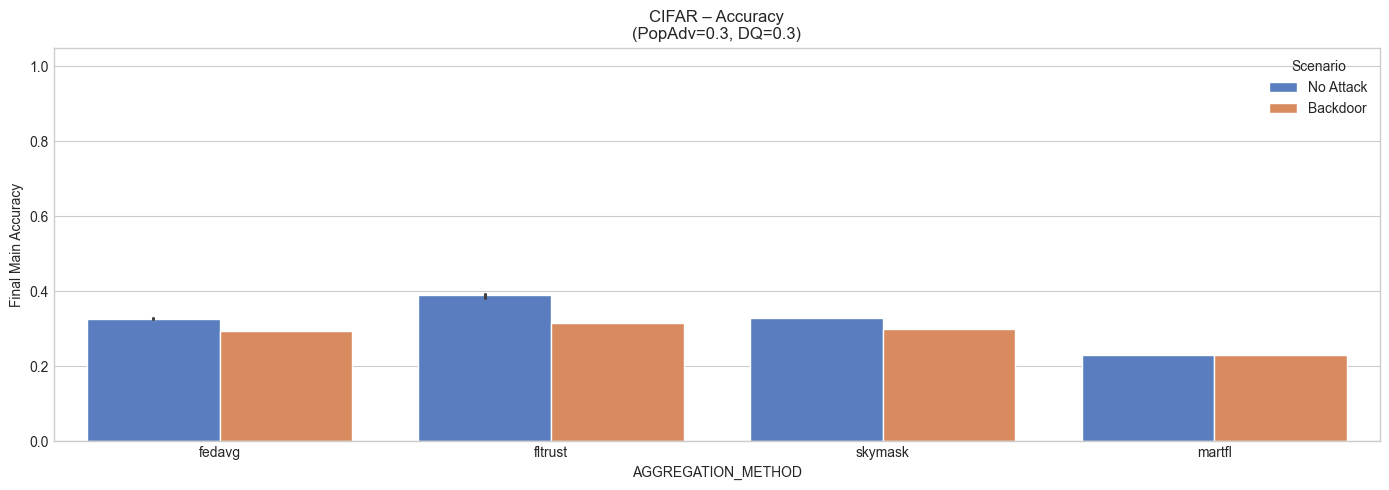

saved results\paper_figures\label_flipping_robustness_csv\acc_CIFAR_Backdoor.pdf


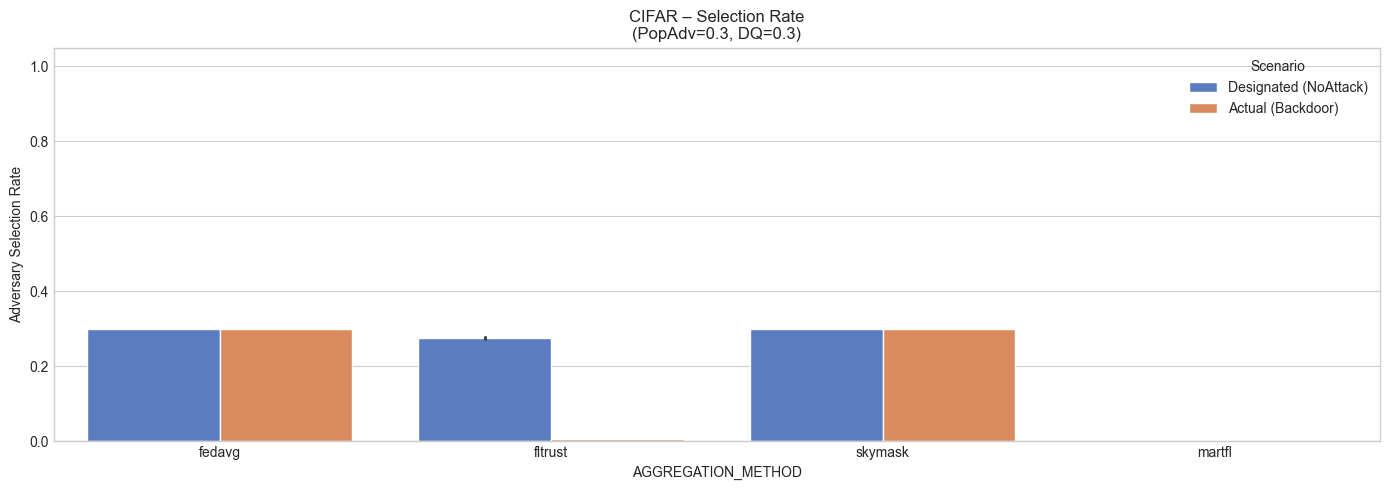

saved results\paper_figures\label_flipping_robustness_csv\sel_CIFAR_Backdoor.pdf
   AGGREGATION_METHOD  FINAL_MAIN_ACC  AVG_ADVERSARY_SELECTION_RATE
39            skymask          0.8900                      0.300000
41             martfl          0.8525                      0.004417
   AGGREGATION_METHOD  FINAL_MAIN_ACC  NO_ATTACK_DESIG_MAL_SEL_RATE_0.3
1              fedavg        0.900350                          0.300000
13            skymask        0.899650                          0.300000
14             fedavg        0.899467                          0.300000
16            fltrust        0.795733                          0.300000
18             martfl        0.850333                          0.332782
20             martfl        0.850333                          0.332782
21            skymask        0.899400                          0.300000
23             fedavg        0.900350                          0.300000
24            fltrust        0.795867                          0.30

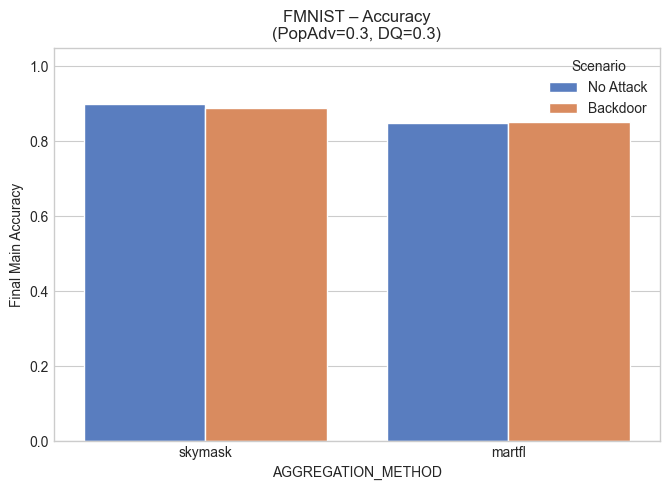

saved results\paper_figures\label_flipping_robustness_csv\acc_FMNIST_Backdoor.pdf


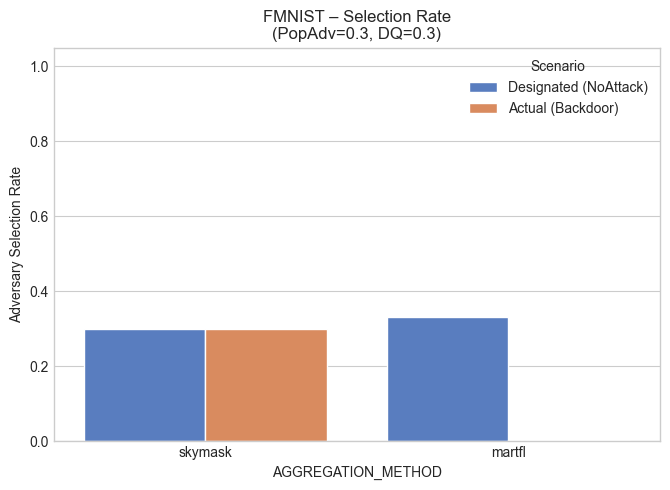

saved results\paper_figures\label_flipping_robustness_csv\sel_FMNIST_Backdoor.pdf
[skip] AG_NEWS: missing rows for attack=Backdoor


In [41]:
for ds in df["DATASET"].unique():
    for atk in ["Backdoor"]:     # add "Backdoor" if needed
        make_barplots(df, ds, atk)

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D # For custom legend (though not used in this cell)

# --- Configuration ---
OUTPUT_DIR = "../result_new"  # Or your actual path
# TARGET_ACCURACY_COC = 0.8 # Not used in Gini/Selection plots, but good to have if other plots use it

# --- Helper Function for Preprocessing ---
def preprocess_experiment_data(df, float_cols_precision=None, categorical_maps=None, verbose=True):
    """
    Preprocesses a DataFrame by converting columns, rounding floats, and mapping categoricals.
    """
    if df.empty:
        if verbose: print("Input DataFrame is empty. Skipping preprocessing.")
        return df.copy() # Return a copy even if empty

    processed_df = df.copy()

    # 1. Map categorical values
    if categorical_maps:
        for col, value_map in categorical_maps.items():
            if col in processed_df.columns:
                original_unique_vals_str = list(map(str, processed_df[col].unique())) # For robust printing
                if verbose: print(f"Column '{col}' before mapping. Unique values (as str): {original_unique_vals_str}")
                # Handle NaN mapping first if present in keys
                if np.nan in value_map:
                    processed_df[col] = processed_df[col].fillna(value_map[np.nan])
                    value_map_no_nan = {k: v for k, v in value_map.items() if not pd.isna(k)}
                    if value_map_no_nan:
                         processed_df[col] = processed_df[col].replace(value_map_no_nan)
                else: # No specific NaN mapping, just replace
                    processed_df[col] = processed_df[col].replace(value_map)
                if verbose: print(f"Column '{col}' mapped. New unique values: {processed_df[col].unique()}")
            elif verbose: print(f"Warning: Column '{col}' for categorical mapping not found in DataFrame.")

    # 2. Convert to numeric and round specified float columns
    if float_cols_precision:
        for col, precision in float_cols_precision.items():
            if col in processed_df.columns: # Check if column exists BEFORE trying to process
                if verbose: print(f"Processing float column: {col} with precision {precision}")
                original_nan_count = processed_df[col].isna().sum()
                numeric_col = pd.to_numeric(processed_df[col], errors='coerce')
                coerced_nan_count = numeric_col.isna().sum()
                if verbose and coerced_nan_count > original_nan_count:
                    print(f"  Warning: Column '{col}' had {coerced_nan_count - original_nan_count} new NaNs after to_numeric (were {original_nan_count}).")
                
                processed_df[col] = numeric_col.round(precision)
                if verbose: print(f"  Column '{col}' rounded. NaNs after rounding: {processed_df[col].isna().sum()}")
            elif verbose: print(f"Warning: Column '{col}' (listed in FLOAT_PRECISIONS) not found in DataFrame.")

    # 3. Specific logic: Set ADV_RATE to 0.0 for 'No Attack' scenarios
    if 'ATTACK_METHOD' in processed_df.columns and 'ADV_RATE' in processed_df.columns:
        if 'No Attack' in processed_df['ATTACK_METHOD'].unique(): # Check if 'No Attack' exists after mapping
            # Ensure ADV_RATE is numeric before this assignment
            if not pd.api.types.is_numeric_dtype(processed_df['ADV_RATE']):
                processed_df['ADV_RATE'] = pd.to_numeric(processed_df['ADV_RATE'], errors='coerce')
            
            processed_df.loc[processed_df['ATTACK_METHOD'] == 'No Attack', 'ADV_RATE'] = 0.0
            if verbose: print("Set ADV_RATE to 0.0 for 'No Attack' scenarios.")
        elif verbose: print("'No Attack' not found in ATTACK_METHOD after mapping; ADV_RATE for 'No Attack' not set to 0.")
    
    return processed_df

# --- Define Preprocessing Parameters ---
FLOAT_PRECISIONS = {
    'ADV_RATE': 1,
    'discovery_quality': 1,
    'FINAL_MAIN_ACC': 4,
    'FINAL_ASR': 4,
    'PAYMENT_GINI_COEFFICIENT': 3,
    'AVG_BENIGN_PAYMENT_GINI': 3, # Assuming this is AVG_BENIGN_PAYMENT_GINI from your CSV
    'AVG_ADVERSARY_SELECTION_RATE': 3, # This is the proportion of *selected* clients that are adversaries
    'AVG_BENIGN_SELLER_SELECTION_RATE': 3, # This might be rate among available benign, or proportion of selected
    'AVG_COST_PER_ROUND': 2, # Overall average cost per round
    'COST_OF_CONVERGENCE': 0, # Assuming integer rounds/costs
    'TOTAL_COST': 0,        # Assuming integer rounds/costs
    'NO_ATTACK_DESIG_MAL_SEL_RATE_0.1': 3,
    'NO_ATTACK_DESIG_MAL_SEL_RATE_0.2': 3,
    'NO_ATTACK_DESIG_MAL_SEL_RATE_0.3': 3,
    'NO_ATTACK_DESIG_MAL_SEL_RATE_0.4': 3,
    # Add derived columns here if you want them rounded by the helper,
    # otherwise, round them after derivation.
    'AVG_COST_PER_ROUND_BENIGN': 2,
    'AVG_COST_PER_ROUND_MALICIOUS': 2
}

CATEGORICAL_MAPPINGS = {
    'ATTACK_METHOD': {
        'single': 'Backdoor', 
        np.nan: 'No Attack',  # Handles empty cells in CSV read as pandas NaN
        'None': 'No Attack',   # Handles cells with string 'None'
        'no_attack': 'No Attack' # Handles cells with string 'no_attack'
    },
    'IS_SYBIL': {
        # Assuming your CSV has string 'False' and string 'mimic'
        # If it's boolean True/False, you'd map them:
        # True: 'mimic', 
        # False: 'False' # Keep 'False' as string 'False' for consistency
    }
}

# --- Load and Preprocess Data ---
summary_df_avg = pd.DataFrame() # Initialize as empty

try:
    summary_df_avg_raw = pd.read_csv(f"{OUTPUT_DIR}/summary_avg.csv")
    print("--- Preprocessing summary_avg.csv ---")
    summary_df_avg = preprocess_experiment_data(
        summary_df_avg_raw,
        float_cols_precision=FLOAT_PRECISIONS,
        categorical_maps=CATEGORICAL_MAPPINGS,
        verbose=True # Enable verbose output for debugging
    )
    
    # --- DERIVE COST COMPOSITION COLUMNS (Benign vs. Malicious Cost per Round) ---
    cost_benign_col = 'AVG_COST_PER_ROUND_BENIGN'
    cost_mal_col = 'AVG_COST_PER_ROUND_MALICIOUS'
    
    # Check if derivation is sensible (i.e., source columns exist)
    if 'AVG_COST_PER_ROUND' in summary_df_avg.columns and \
       'AVG_ADVERSARY_SELECTION_RATE' in summary_df_avg.columns:
        
        print("Deriving cost composition (benign/malicious) from AVG_COST_PER_ROUND and AVG_ADVERSARY_SELECTION_RATE.")
        
        # Ensure source columns are numeric (they should be after preprocess_experiment_data if listed in FLOAT_PRECISIONS)
        # If not listed, convert them here explicitly before use.
        for col_to_check in ['AVG_COST_PER_ROUND', 'AVG_ADVERSARY_SELECTION_RATE']:
            if col_to_check not in FLOAT_PRECISIONS: # If not already processed by helper
                 if col_to_check in summary_df_avg.columns:
                    summary_df_avg[col_to_check] = pd.to_numeric(summary_df_avg[col_to_check], errors='coerce')
                    print(f"  Ensured column '{col_to_check}' is numeric for derivation.")
                 else:
                    print(f"  Warning: Source column '{col_to_check}' for derivation not found.")
                    # Create empty columns to prevent later key errors if derivation fails
                    summary_df_avg[cost_mal_col] = np.nan
                    summary_df_avg[cost_benign_col] = np.nan


        # For "No Attack" runs, AVG_ADVERSARY_SELECTION_RATE should be 0 for this calculation.
        # The preprocess_experiment_data sets ADV_RATE to 0.
        # Your data generation script should ensure AVG_ADVERSARY_SELECTION_RATE is 0 for No Attack runs.
        # If it might be NaN for No Attack runs, fill it with 0 before calculation.
        adv_sel_rate_for_calc = summary_df_avg['AVG_ADVERSARY_SELECTION_RATE'].copy()
        # If ATTACK_METHOD is 'No Attack', this rate is definitionally 0.
        # Also, if it's NaN for an attack run (shouldn't happen if data is good), treat as 0 for safety here.
        adv_sel_rate_for_calc[summary_df_avg['ATTACK_METHOD'] == 'No Attack'] = 0.0
        adv_sel_rate_for_calc.fillna(0.0, inplace=True) # Fill any other NaNs with 0 to avoid NaN propagation

        # Calculate derived costs
        summary_df_avg[cost_mal_col] = summary_df_avg['AVG_COST_PER_ROUND'] * adv_sel_rate_for_calc
        summary_df_avg[cost_benign_col] = summary_df_avg['AVG_COST_PER_ROUND'] * (1 - adv_sel_rate_for_calc)
        
        # Round the newly derived columns if they weren't already in FLOAT_PRECISIONS
        # or if derivation might have introduced new float precision issues.
        if cost_mal_col in summary_df_avg.columns:
            summary_df_avg[cost_mal_col] = summary_df_avg[cost_mal_col].round(FLOAT_PRECISIONS.get(cost_mal_col, 2))
        if cost_benign_col in summary_df_avg.columns:
            summary_df_avg[cost_benign_col] = summary_df_avg[cost_benign_col].round(FLOAT_PRECISIONS.get(cost_benign_col, 2))
        print("Derived and processed cost composition columns.")
        
    else:
        print("Warning: Cannot derive cost composition. Missing 'AVG_COST_PER_ROUND' or 'AVG_ADVERSARY_SELECTION_RATE'.")
        # Ensure columns exist as NaN if derivation fails, for consistency in later plotting cells
        if cost_mal_col not in summary_df_avg.columns: summary_df_avg[cost_mal_col] = np.nan
        if cost_benign_col not in summary_df_avg.columns: summary_df_avg[cost_benign_col] = np.nan


    print(f"Processed summary_df_avg shape: {summary_df_avg.shape}")
    if not summary_df_avg.empty:
        print("\nFirst 5 rows of processed summary_df_avg (after potential derivation):")
        display(summary_df_avg.head())
        print("\nInfo of processed summary_df_avg:")
        summary_df_avg.info()

except FileNotFoundError:
    print(f"CRITICAL ERROR: summary_avg.csv not found in {OUTPUT_DIR}. Cannot proceed with plotting.")
    summary_df_avg = pd.DataFrame() # Ensure it's an empty DF if load fails
except Exception as e:
    print(f"CRITICAL ERROR: An error occurred during summary_df_avg loading or preprocessing: {e}")
    summary_df_avg = pd.DataFrame()

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")
try:
    all_rounds_df_raw = pd.read_csv(f"{OUTPUT_DIR}/all_rounds.csv")
    print("\nall_rounds.csv loaded successfully.")
    all_rounds_df = preprocess_experiment_data(
        all_rounds_df_raw,
        float_cols_precision=FLOAT_PRECISIONS,
        categorical_maps=CATEGORICAL_MAPPINGS
    )
    print(f"Processed all_rounds_df shape: {all_rounds_df.shape}")
    if not all_rounds_df.empty: display(all_rounds_df.head())
except FileNotFoundError:
    print(f"Error: all_rounds.csv not found in {OUTPUT_DIR}. Please check the path.")
    all_rounds_df = pd.DataFrame()

# Set a consistent style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")

# --- Verification ---
if not summary_df_avg.empty:
    print("\n--- Processed Summary Data Verification (Post-Preprocessing & Derivation) ---")
    check_cols = [
        'AGGREGATION_METHOD', 'ATTACK_METHOD', 'IS_SYBIL', 'ADV_RATE',
        'BENIGN_PAYMENT_GINI_COEFFICIENT', # This is your AVG_BENIGN_PAYMENT_GINI
        'AVG_BENIGN_SELLER_SELECTION_RATE', 
        'AVG_ADVERSARY_SELECTION_RATE',
        'AVG_COST_PER_ROUND_BENIGN', # New derived/processed
        'AVG_COST_PER_ROUND_MALICIOUS', # New derived/processed
        'NO_ATTACK_DESIG_MAL_SEL_RATE_0.1', 'NO_ATTACK_DESIG_MAL_SEL_RATE_0.2',
        'NO_ATTACK_DESIG_MAL_SEL_RATE_0.3', 'NO_ATTACK_DESIG_MAL_SEL_RATE_0.4'
    ]
    for col in check_cols:
        if col in summary_df_avg.columns:
            unique_vals = summary_df_avg[col].unique()
            try:
                if pd.api.types.is_numeric_dtype(summary_df_avg[col].dtype) and not summary_df_avg[col].empty:
                    valid_numeric_vals = summary_df_avg[col].dropna().unique()
                    unique_vals = sorted(list(valid_numeric_vals)) if len(valid_numeric_vals) > 0 else []
                elif not summary_df_avg[col].empty:
                    # Attempt to sort strings, handle mixed types by converting all to string for sorting
                    unique_vals = sorted(list(map(str, unique_vals)))
            except TypeError:
                 print(f"    (Could not sort unique values for {col} due to mixed types or NaNs)")
                 pass 
            print(f"Unique values in '{col}': {unique_vals}")
            print(f"  NaNs in '{col}': {summary_df_avg[col].isna().sum()}")
        else:
            print(f"VERIFICATION WARNING: Column '{col}' NOT FOUND in processed summary_df_avg.")
else:
    print("\nsummary_df_avg is empty. Verification skipped. Subsequent plots will likely fail.")

--- Preprocessing summary_avg.csv ---
Column 'ATTACK_METHOD' before mapping. Unique values (as str): ['nan', 'single']
Column 'ATTACK_METHOD' mapped. New unique values: ['No Attack' 'Backdoor']
Column 'IS_SYBIL' before mapping. Unique values (as str): ['False', 'default']
Column 'IS_SYBIL' mapped. New unique values: ['False' 'default']
Processing float column: ADV_RATE with precision 1
  Column 'ADV_RATE' rounded. NaNs after rounding: 0
Processing float column: discovery_quality with precision 1
  Column 'discovery_quality' rounded. NaNs after rounding: 0
Processing float column: FINAL_MAIN_ACC with precision 4
  Column 'FINAL_MAIN_ACC' rounded. NaNs after rounding: 0
Processing float column: FINAL_ASR with precision 4
  Column 'FINAL_ASR' rounded. NaNs after rounding: 38
Processing float column: PAYMENT_GINI_COEFFICIENT with precision 3
  Column 'PAYMENT_GINI_COEFFICIENT' rounded. NaNs after rounding: 0
Processing float column: AVG_BENIGN_PAYMENT_GINI with precision 3
  Column 'AVG_BE

,AVG_BENIGN_SELLER_SELECTION_RATE,NO_ATTACK_DESIG_MAL_SEL_RATE_0.1,DATA_SPLIT_MODE,LOCAL_EPOCH,benign_rounds,AVG_SELECTED_DISTRIBUTION_SIMILARITY,NO_ATTACK_DESIG_MAL_SEL_RATE_0.2,COST_TO_80ACC,ATTACK_METHOD,AVG_BENIGN_SELECTION_RATE,...,N_CLIENTS,COST_TO_85ACC,COST_OF_CONVERGENCE,FINAL_MAIN_ACC,COC_TARGET_REACHED_ROUND,buyer_data_mode,AVG_ADVERSARY_SELECTION_RATE,exp_path,AVG_COST_PER_ROUND_MALICIOUS,AVG_COST_PER_ROUND_BENIGN
0,1.000,0.1,discovery,2,5.0,0.0,0.2,NaN,No Attack,1.000000,...,10,NaN,NaN,0.3304,-1.0,unbiased,0.000,./experiment_results_revised/privacy/gradient_...,0.00,10.00
1,1.000,0.1,discovery,2,5.0,0.0,0.2,180.000000,No Attack,1.000000,...,10,355.0,180.0,0.9004,17.0,unbiased,0.000,./experiment_results_revised/privacy/gradient_...,0.00,10.00
2,1.000,NaN,discovery,2,5.0,0.0,NaN,NaN,Backdoor,0.700000,...,10,NaN,NaN,0.2966,-1.0,unbiased,0.300,./experiment_results_revised/label_flip_attack...,3.00,7.00
3,0.145,NaN,discovery,2,5.0,0.0,NaN,98.666667,Backdoor,0.667218,...,10,165.0,99.0,0.8006,23.0,unbiased,0.333,./experiment_results_revised/label_flip_attack...,0.46,0.92
4,0.698,NaN,discovery,2,5.0,0.0,NaN,NaN,Backdoor,0.733974,...,10,NaN,NaN,0.3318,-1.0,unbiased,0.261,./experiment_results_revised/label_flip_attack...,1.73,4.91



Info of processed summary_df_avg:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 49 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   AVG_BENIGN_SELLER_SELECTION_RATE        44 non-null     float64
 1   NO_ATTACK_DESIG_MAL_SEL_RATE_0.1        30 non-null     float64
 2   DATA_SPLIT_MODE                         44 non-null     object 
 3   LOCAL_EPOCH                             44 non-null     int64  
 4   benign_rounds                           44 non-null     float64
 5   AVG_SELECTED_DISTRIBUTION_SIMILARITY    44 non-null     float64
 6   NO_ATTACK_DESIG_MAL_SEL_RATE_0.2        30 non-null     float64
 7   COST_TO_80ACC                           17 non-null     float64
 8   ATTACK_METHOD                           44 non-null     object 
 9   AVG_BENIGN_SELECTION_RATE               44 non-null     float64
 10  CHANGE_BASE                  

C:\Users\zeyu song\AppData\Local\Temp\ipykernel_521332\3400834328.py:189: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  all_rounds_df_raw = pd.read_csv(f"{OUTPUT_DIR}/all_rounds.csv")


,run,round,ATTACK_METHOD,TRIGGER_RATE,IS_SYBIL,ADV_RATE,CHANGE_BASE,benign_rounds,attack_objective,AGGREGATION_METHOD,...,NO_ATTACK_DESIG_MAL_SEL_RATE_0.2_ROUND,NO_ATTACK_DESIG_MAL_SEL_RATE_0.3_ROUND,NO_ATTACK_DESIG_MAL_SEL_RATE_0.4_ROUND,main_acc,main_loss,clean_acc,triggered_acc,asr,avg_selected_data_distribution_similarity,avg_unselected_data_distribution_similarity
0,0,0,No Attack,0.0,False,0.0,False,5,backdoor,fedavg,...,0.2,0.3,0.4,0.1808,2.227143,NaN,NaN,NaN,0,0.966503
1,0,1,No Attack,0.0,False,0.0,False,5,backdoor,fedavg,...,0.2,0.3,0.4,0.1982,2.216200,NaN,NaN,NaN,0,0.966503
2,0,2,No Attack,0.0,False,0.0,False,5,backdoor,fedavg,...,0.2,0.3,0.4,0.2201,2.215716,NaN,NaN,NaN,0,0.966503
3,0,3,No Attack,0.0,False,0.0,False,5,backdoor,fedavg,...,0.2,0.3,0.4,0.2271,2.210321,NaN,NaN,NaN,0,0.966503
4,0,4,No Attack,0.0,False,0.0,False,5,backdoor,fedavg,...,0.2,0.3,0.4,0.2100,2.207177,NaN,NaN,NaN,0,0.966503



--- Processed Summary Data Verification (Post-Preprocessing & Derivation) ---
Unique values in 'AGGREGATION_METHOD': ['fedavg', 'fltrust', 'martfl', 'skymask']
  NaNs in 'AGGREGATION_METHOD': 0
Unique values in 'ATTACK_METHOD': ['Backdoor', 'No Attack']
  NaNs in 'ATTACK_METHOD': 0
Unique values in 'IS_SYBIL': ['False', 'default']
  NaNs in 'IS_SYBIL': 0
Unique values in 'ADV_RATE': [np.float64(0.0), np.float64(0.3)]
  NaNs in 'ADV_RATE': 0
VERIFICATION WARNING: Column 'BENIGN_PAYMENT_GINI_COEFFICIENT' NOT FOUND in processed summary_df_avg.
Unique values in 'AVG_BENIGN_SELLER_SELECTION_RATE': [np.float64(0.104), np.float64(0.11), np.float64(0.145), np.float64(0.146), np.float64(0.231), np.float64(0.25), np.float64(0.252), np.float64(0.255), np.float64(0.298), np.float64(0.381), np.float64(0.489), np.float64(0.565), np.float64(0.639), np.float64(0.643), np.float64(0.692), np.float64(0.698), np.float64(0.998), np.float64(0.999), np.float64(1.0)]
  NaNs in 'AVG_BENIGN_SELLER_SELECTION_RA

Original data shape: (44, 49)
    AVG_BENIGN_SELLER_SELECTION_RATE  NO_ATTACK_DESIG_MAL_SEL_RATE_0.1  \
1                           1.000000                          0.100000   
3                           0.144524                               NaN   
5                           1.000000                               NaN   
7                           1.000000                               NaN   
8                           1.000000                               NaN   
13                          1.000000                          0.100000   
14                          1.000000                          0.100000   
16                          1.000000                          0.100000   
18                          0.109500                          0.000907   
20                          0.109500                          0.000907   
21                          1.000000                          0.100000   
23                          1.000000                          0.100000   
24      

C:\Users\zeyu song\AppData\Local\Temp\ipykernel_521332\1179332848.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data_milestones_filtered[col] = pd.to_numeric(plot_data_milestones_filtered[col], errors='coerce')


Saved figure: results\paper_figures\milestone_plots_fixed\milestones_speed_fmnist_adv30.pdf


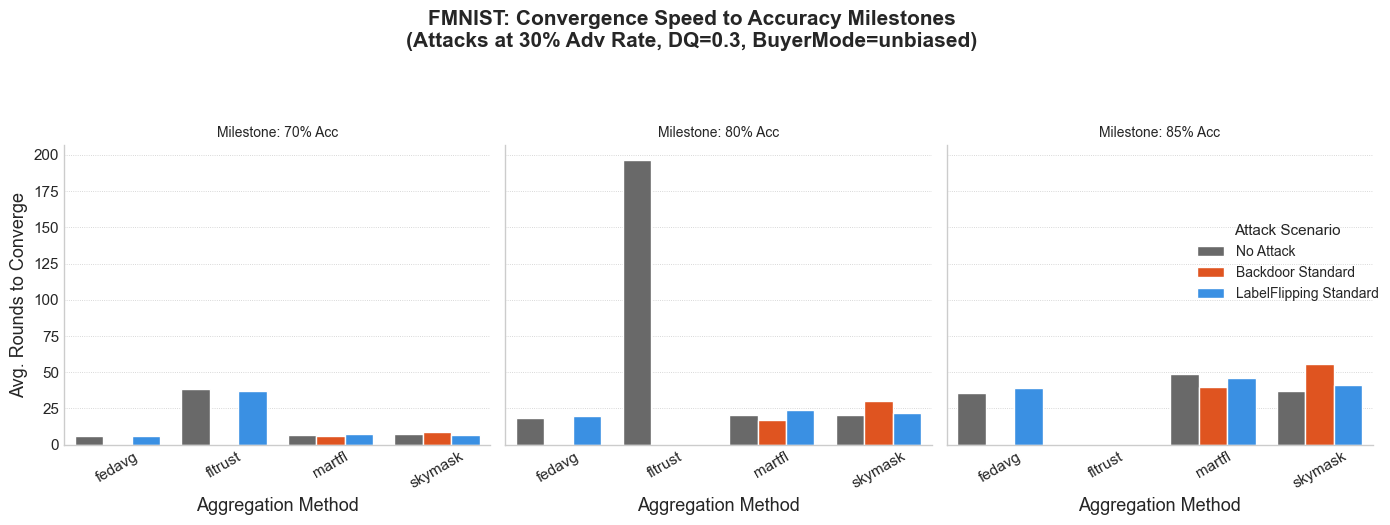

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# --- Plotting Configuration ---
FIGURE_SAVE_DIR = Path("./results/paper_figures/milestone_plots_fixed")
FIGURE_SAVE_DIR.mkdir(parents=True, exist_ok=True)
TITLE_FONT_SIZE = 15
AXIS_LABEL_FONT_SIZE = 13
TICK_LABEL_FONT_SIZE = 11
LEGEND_FONT_SIZE = 10
LEGEND_TITLE_FONT_SIZE = 11
SUPTITLE_Y_POS = 1.04 # Position of suptitle

# Filters for the data to plot
FIXED_POP_ADV_RATE_FOR_ATTACK_SCENARIOS = 0.3
DISCOVERY_QUALITY_FILTER = 0.3
BUYER_MODE_FILTER = "unbiased"
DATASET_TO_PLOT = "FMNIST"

# Milestones: Define the labels and corresponding column names
MILESTONE_ACC_LABELS_TO_PLOT = ["70", "80", "85"] # The labels you want to see
MILESTONE_COL_BASENAMES = [f'ROUNDS_TO_{label}ACC' for label in MILESTONE_ACC_LABELS_TO_PLOT]

# Aggregation methods: If you want a specific order, define it. Otherwise, sorted unique values will be used.
# AGGREGATION_METHODS_ORDER_PREFERENCE = ['FedAvg', 'Krum', 'MartFL', 'SomeOtherMethod']
AGGREGATION_METHODS_ORDER_PREFERENCE = sorted(summary_df_avg['AGGREGATION_METHOD'].unique())

summary_df_avg = load_and_tag(CSV_PATH)
# Palette for Attack Scenarios
CONDITION_PALETTE_MAP = {
    'No Attack': 'dimgray',
    'Backdoor Standard': 'orangered',
    'Backdoor Sybil': 'darkviolet',
    'LabelFlipping Standard': 'dodgerblue', # Example if you add more
}

def save_figure_as_pdf(fig, output_directory, base_filename, dataset_name=None, other_details=None):
    """Helper to save figures with consistent naming."""
    Path(output_directory).mkdir(parents=True, exist_ok=True)
    filename_parts = [base_filename]
    if dataset_name:
        filename_parts.append(dataset_name.lower().replace(" ", "_"))
    if other_details:
        filename_parts.append(other_details.replace(" ", "_"))
    final_filename = "_".join(filename_parts) + ".pdf"
    save_path = Path(output_directory) / final_filename
    try:
        fig.savefig(save_path, bbox_inches='tight', format='pdf')
        print(f"Saved figure: {save_path}")
    except Exception as e:
        print(f"Error saving figure {save_path}: {e}")

# --- Main Plotting Logic ---
if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    plot_data_milestones_orig = summary_df_avg.copy()

    # --- Pre-filter data based on global settings ---
    print(f"Original data shape: {plot_data_milestones_orig.shape}")
    plot_data_milestones_filtered = plot_data_milestones_orig[
        (plot_data_milestones_orig['DATASET'].astype(str).str.upper() == DATASET_TO_PLOT.upper()) &
        (np.isclose(plot_data_milestones_orig['discovery_quality'], DISCOVERY_QUALITY_FILTER)) &
        (plot_data_milestones_orig['buyer_data_mode'].astype(str) == BUYER_MODE_FILTER)
    ]
    print(plot_data_milestones_filtered)
    print(f"Data shape after primary filters (Dataset, DQ, BuyerMode): {plot_data_milestones_filtered.shape}")

    if plot_data_milestones_filtered.empty:
        print(f"No data found for Dataset={DATASET_TO_PLOT}, DQ={DISCOVERY_QUALITY_FILTER}, BuyerMode={BUYER_MODE_FILTER}. Skipping plot.")
    else:
        # Verify all chosen milestone columns exist in the filtered DataFrame
        actual_milestone_cols_present = [col for col in MILESTONE_COL_BASENAMES if col in plot_data_milestones_filtered.columns]
        if not actual_milestone_cols_present:
            print(f"Error: None of the specified milestone columns {MILESTONE_COL_BASENAMES} exist in the filtered data. Cannot create plot.")
        elif plot_data_milestones_filtered[actual_milestone_cols_present].isna().all().all():
            print(f"Error: All available milestone columns ({actual_milestone_cols_present}) are entirely NaN for the filtered data. Cannot create plot.")
        else:
            # Ensure milestone columns are numeric
            for col in actual_milestone_cols_present:
                plot_data_milestones_filtered[col] = pd.to_numeric(plot_data_milestones_filtered[col], errors='coerce')

            # --- Prepare Data for Grouped Bar Chart (Melting and Further Filtering) ---
            data_for_plot_list = []

            # Define attack types to extract and their corresponding conditions
            # (EFFECTIVE_ATTACK_VALUE, IS_SYBIL_VALUE_AS_STRING, DISPLAY_LABEL)
            attack_configurations = [
                ('Backdoor', 'False', 'Backdoor Standard'),
                ('Backdoor', 'mimic', 'Backdoor Sybil'),
                ('LabelFlipping', 'False', 'LabelFlipping Standard'), # Add more if needed
                ('LabelFlipping', 'mimic', 'LabelFlipping Sybil'), # Add more if needed
            ]

            # Iterate over each aggregation method to build the data
            unique_agg_methods_in_filtered_data = sorted(plot_data_milestones_filtered['AGGREGATION_METHOD'].unique())
            
            # Use AGGREGATION_METHODS_ORDER_PREFERENCE if it has overlap, else just use unique from data
            agg_methods_for_plot = [m for m in AGGREGATION_METHODS_ORDER_PREFERENCE if m in unique_agg_methods_in_filtered_data]
            if not agg_methods_for_plot: # Fallback if preference list doesn't match data
                agg_methods_for_plot = unique_agg_methods_in_filtered_data
            
            print(f"Aggregation methods considered for plot: {agg_methods_for_plot}")


            for agg_method in agg_methods_for_plot:
                df_agg_method = plot_data_milestones_filtered[plot_data_milestones_filtered['AGGREGATION_METHOD'] == agg_method]
                if df_agg_method.empty:
                    continue

                # 1. No Attack Data
                no_attack_rows = df_agg_method[df_agg_method['ADV_RATE_effective'].eq(0) | (df_agg_method['EFFECTIVE_ATTACK'] == 'No Attack')]
                if not no_attack_rows.empty:
                    # Take the mean if multiple 'No Attack' rows exist for an agg_method (e.g. different seeds)
                    no_attack_avg_rounds = no_attack_rows[actual_milestone_cols_present].mean()
                    for col_basename, acc_label_str in zip(MILESTONE_COL_BASENAMES, MILESTONE_ACC_LABELS_TO_PLOT):
                        if col_basename in no_attack_avg_rounds.index:
                            avg_rounds_value = no_attack_avg_rounds[col_basename]
                            if pd.notna(avg_rounds_value):
                                data_for_plot_list.append({
                                    'Aggregation Method': agg_method,
                                    'Attack Scenario': 'No Attack',
                                    'Milestone Target': f'{acc_label_str}% Acc',
                                    'Rounds to Converge': avg_rounds_value
                                })
                # 2. Specific Attack Data
                for eff_attack_val, is_sybil_val_str, display_label in attack_configurations:
                    attack_rows = df_agg_method[
                        (df_agg_method['EFFECTIVE_ATTACK'] == eff_attack_val) &
                        (df_agg_method['IS_SYBIL'].astype(str) == is_sybil_val_str) &
                        (np.isclose(df_agg_method['ADV_RATE_effective'], FIXED_POP_ADV_RATE_FOR_ATTACK_SCENARIOS))
                    ]
                    if not attack_rows.empty:
                        # Take the mean if multiple rows exist for this specific attack config (e.g. different seeds)
                        attack_avg_rounds = attack_rows[actual_milestone_cols_present].mean()
                        for col_basename, acc_label_str in zip(MILESTONE_COL_BASENAMES, MILESTONE_ACC_LABELS_TO_PLOT):
                             if col_basename in attack_avg_rounds.index:
                                avg_rounds_value = attack_avg_rounds[col_basename]
                                if pd.notna(avg_rounds_value):
                                    data_for_plot_list.append({
                                        'Aggregation Method': agg_method,
                                        'Attack Scenario': display_label,
                                        'Milestone Target': f'{acc_label_str}% Acc',
                                        'Rounds to Converge': avg_rounds_value
                                    })
            
            df_for_bars_final = pd.DataFrame(data_for_plot_list)
            print(f"Shape of data prepared for catplot (df_for_bars_final): {df_for_bars_final.shape}")
            if not df_for_bars_final.empty:
                print("Unique 'Aggregation Method' in df_for_bars_final:", df_for_bars_final['Aggregation Method'].unique())
                print("Unique 'Attack Scenario' in df_for_bars_final:", df_for_bars_final['Attack Scenario'].unique())
                print("Unique 'Milestone Target' in df_for_bars_final:", df_for_bars_final['Milestone Target'].unique())


            # --- Plotting Grouped Bar Chart using catplot ---
            if not df_for_bars_final.empty:
                # Determine the order for hue and columns strictly from the data to be plotted
                actual_agg_methods_in_plot = sorted(df_for_bars_final['Aggregation Method'].unique())
                actual_attack_scenarios_in_plot = sorted(df_for_bars_final['Attack Scenario'].unique())
                # Ensure milestone order is consistent with MILESTONE_ACC_LABELS_TO_PLOT for those present
                actual_milestones_in_plot_ordered = [f"{label}% Acc" for label in MILESTONE_ACC_LABELS_TO_PLOT if f"{label}% Acc" in df_for_bars_final['Milestone Target'].unique()]


                # Filter palette to only include conditions present in the data
                active_palette = {k: v for k, v in CONDITION_PALETTE_MAP.items() if k in actual_attack_scenarios_in_plot}
                
                # Ensure hue_order only contains scenarios present and in a preferred order if possible
                preferred_hue_order = [scen for scen in ['No Attack'] + [cfg[2] for cfg in attack_configurations] if scen in actual_attack_scenarios_in_plot]


                print(f"\n--- Catplot Parameters ---")
                print(f"X (Aggregation Method) order: {actual_agg_methods_in_plot}")
                print(f"Hue (Attack Scenario) order: {preferred_hue_order}")
                print(f"Col (Milestone Target) order: {actual_milestones_in_plot_ordered}")
                print(f"Active Palette: {active_palette}")


                if not actual_milestones_in_plot_ordered:
                    print("No milestones to plot after filtering. Skipping catplot.")
                else:
                    g = sns.catplot(
                        data=df_for_bars_final,
                        x='Aggregation Method',
                        y='Rounds to Converge',
                        hue='Attack Scenario',
                        col='Milestone Target', # Facet by milestone
                        kind='bar',
                        order=actual_agg_methods_in_plot, # Order for x-axis
                        hue_order=preferred_hue_order,    # Order for hue legend
                        col_order=actual_milestones_in_plot_ordered, # Order for facets/columns
                        palette=active_palette,
                        height=5,
                        aspect=max(0.4, 0.2 * len(actual_agg_methods_in_plot)), # Dynamic aspect ratio
                        errorbar=None, # Data is already averaged
                        legend_out=True,
                        sharey=True # Keep Y-axis consistent across facets, or False if ranges differ wildly
                    )

                    # Titles and Labels
                    g.set_axis_labels("Aggregation Method", "Avg. Rounds to Converge", fontsize=AXIS_LABEL_FONT_SIZE)
                    g.set_titles("Milestone: {col_name}", fontsize=AXIS_LABEL_FONT_SIZE) # Titles for each facet
                    for ax in g.axes.flat:
                        ax.tick_params(axis='x', labelrotation=30, labelsize=TICK_LABEL_FONT_SIZE) # Rotate x-labels
                        ax.tick_params(axis='y', labelsize=TICK_LABEL_FONT_SIZE)
                        ax.grid(True, which='major', linestyle=':', linewidth=0.6, axis='y')
                        ax.set_axisbelow(True)

                    # Adjust legend
                    if g.legend:
                        g.legend.set_title("Attack Scenario", prop={'size': LEGEND_TITLE_FONT_SIZE})
                        plt.setp(g.legend.get_texts(), fontsize=LEGEND_FONT_SIZE)


                    main_plot_title = (
                        f'{DATASET_TO_PLOT}: Convergence Speed to Accuracy Milestones\n'
                        f'(Attacks at {FIXED_POP_ADV_RATE_FOR_ATTACK_SCENARIOS*100:.0f}% Adv Rate, '
                        f'DQ={DISCOVERY_QUALITY_FILTER}, BuyerMode={BUYER_MODE_FILTER})'
                    )
                    plt.suptitle(main_plot_title, y=SUPTITLE_Y_POS, fontsize=TITLE_FONT_SIZE, fontweight='bold')
                    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust rect to make space for suptitle

                    save_figure_as_pdf(
                        fig=plt.gcf(), # g.fig would also work
                        output_directory=FIGURE_SAVE_DIR,
                        base_filename=f"milestones_speed",
                        dataset_name=DATASET_TO_PLOT,
                        other_details=f"adv{int(FIXED_POP_ADV_RATE_FOR_ATTACK_SCENARIOS*100)}"
                    )
                    plt.show()
            else:
                print(f"Data for plotting (df_for_bars_final) is empty for {DATASET_TO_PLOT}. Cannot create catplot.")
else:
    print("DataFrame 'summary_df_avg' is not available or empty. Skipping milestone speed plot.")